# Christoffel module step by step

In [1]:
# import some general scientific Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import required PyRockWave modules
import christoffel as ch
import coordinates as c

The goal of PyRockWave's Christoffel module is to estimate various seismic properties as a function of propagation direction using the Christoffel equation (Christoffel, 1877). These properties include the $V_p$ (compressional), $V_{s1}$, $V_{s2}$ (shear) phase and group sound wave velocities in km/s, the polarisation directions of the sound waves, the shear wave splitting, the coordinates of the ray surface, the power flow angle and the enhancement factor. We will define all these parameters throughout this notebook.

## Input data

The data required to estimate the seismic properties in any direction of a given material using the Christoffel equation are the density and the stiffness tensor of the material.

The stiffness tensor $C$ is a fundamental property of a material that generalises Hooke's law in three dimensions, relating strains to stresses in the elastic regime. This is usually given (or abbreviated) in a 6x6 matrix ($C_{ij}$) using Voigt notation with values given in $GPa$. The density is usually given in $g/cm^3$.

> _Other material properties unrelated to seismic waves that can be derived from these data are: Young modulus, shear modulus, Poisson's ratio, linear compresibility and Debye temperature._

In [2]:
# load test data
Cij = np.array([[118.8,  53.8,  53.8,   0. ,   0. ,   0. ],
                [ 53.8, 118.8,  53.8,   0. ,   0. ,   0. ],
                [ 53.8,  53.8, 118.8,   0. ,   0. ,   0. ],
                [  0. ,   0. ,   0. ,  59.4,   0. ,   0. ],
                [  0. ,   0. ,   0. ,   0. ,  59.4,   0. ],
                [  0. ,   0. ,   0. ,   0. ,   0. ,  59.4]])

density = 5.307

## Step 0: create an array with wave vectors

For most materials, the seismic properties are anisotropic, i.e. they depend on the direction. Accordingly, the Christoffel equation must be solved for each propagation direction of interest, and we must first define these directions, denoted as wave vectors or $\vec{q}$. Wave vectors can be defined in spherical coordinates (polar and azimuthal angles) or in Cartesian coordinates ($x, y, z$) normalised to the unit sphere (i.e. vectors of size 1 or unit vectors). Cartesian coordinates are typically used for calculations. In this case we will use the following procedure:

- Create equispaced wavevectors in spherical coordinates
- Convert from spherical to 3D Cartesian unit vectors
- Store the wave vectors in a single array with three columns ($x, y, z$) for calculations

In [3]:
# create equispaced wavevectors in spherical coordinates (in radians)
azimuths, polar = c.equispaced_S2_grid(n=450)

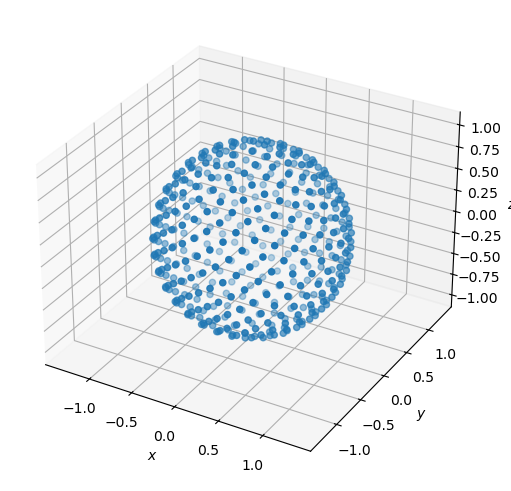

In [4]:
# convert from spherical to 3d cartesian
x, y, z = c.sph2cart(azimuths, polar)

# plot to test
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
ax.scatter(x, y, z)
ax.axis('equal')
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

In [5]:
# Store wavevectors in a single Numpy array for calculations
wavevectors = np.column_stack((x, y, z))

wavevectors.shape

(450, 3)

## Step 1: Rearrange to a tensor $Cij → Cijkl$

The operations to solve the Christoffel equation require the stiffness tensor to be in its tensor format, i.e. with its original form 3x3x3x3 (rank 4, dimension 3), rather than as a 6x6 matrix as normally provided, so it is necessary to convert $C_{ij}$ to $C_{ijkl}$.

In [6]:
Cijkl = ch._rearrange_tensor(Cij)

Cijkl.shape

(3, 3, 3, 3)

## Step 2: Estimate the Christoffel matrices for each wavevector $\vec{q}$

TODO

$$
q_j \, C_{ijkl} \, q_k =  \rho \frac{\omega^2}{k^2} s_i
$$

where...TODO

The Christoffel matrix for a given direction is determined as follows:

$$
M_{il} = \sum_{jk} q_j \, C_{ijkl} \, q_k
$$

In [7]:
Mil = ch._christoffel_matrix(wavevectors, Cijkl)

Mil.shape

(450, 3, 3)

## Step 3: Normalize the Christoffel matrices

$$
M_{il(norm)} = \frac{M_{il}}{\rho}
$$

In [8]:
norm_Mil = Mil / density

In [9]:
# check
Mil[0], norm_Mil[0]

(array([[ 59.4,   0. ,   0. ],
        [  0. ,  59.4,   0. ],
        [  0. ,   0. , 118.8]]),
 array([[11.19276427,  0.        ,  0.        ],
        [ 0.        , 11.19276427,  0.        ],
        [ 0.        ,  0.        , 22.38552855]]))

## Step 4: Estimate the eigenvalues $\lambda$ and eigenvectors $\vec{v}$

TODO

In [10]:
eigenvalues, eigenvectors = ch._calc_eigen(norm_Mil)

eigenvalues.shape, eigenvectors.shape

((450, 3), (450, 3, 3))

## Step 5: Calculate phase velocities ($v_p$)

**Phase velocity** represents the speed at which an individual wave (such as the crest or valley) propagates through a medium. In particular, it denotes the velocity of a single frequency component within a wave packet. Phase velocity depends on the material (rock type) and the wave's frequency due to dispersion in Earth materials. As with any wave, its velocity is defined as the ratio of the wave’s frequency ($\omega$) to its wavelength ($\kappa$).

The eigenvalues $\lambda_1$, $\lambda_2$ and $\lambda_3$ of the Christoffel tensor ($M_{il}$), which are always real and positive, are related to the phase compressional and shear wave velocities $V_p$, $V_{s1}$, $V_{s2}$ propagating in a direction $\vec{n}$ by the formulae:

$$
V_p = \sqrt{ \frac{\lambda_1}{\rho} }, \quad V_{s1} = \sqrt{ \frac{\lambda_2}{\rho} }, \quad V_{s2} = \sqrt{ \frac{\lambda_3}{\rho} }
$$

where $\rho$ is the material density. If the Christoffel tensor has already been normalised with respect to the density, the general formulae are as follows:

$$
v_p = \sqrt{\lambda_n}, \quad \lambda_n = v^2_p
$$

where $v_p$ denotes the phase velocities and $\lambda_n$ the different eigenvalues. The output will be an array of shape $(n, 3)$, where $n$ represents the number of wave vectors (orientations) considered and the seconf dimension the $V_p$, $V_{s1}$, $V_{s2}$ velocities.

In [11]:
phase_velocities = ch.calc_phase_velocities(eigenvalues)

phase_velocities.shape

(450, 3)

In [12]:
# display the phase velocities for the first ten directions [Vs2, Vs1, Vp]
phase_velocities[:10, :]

array([[3.34555889, 3.34555889, 4.73133475],
       [3.22699536, 3.34555889, 4.8129818 ],
       [3.22131796, 3.31706989, 4.83644653],
       [3.16507091, 3.34467131, 4.85453984],
       [3.16942196, 3.30715217, 4.87735236],
       [3.11077812, 3.34078505, 4.89216433],
       [3.11716631, 3.30249217, 4.91404892],
       [3.06454589, 3.33236485, 4.92696256],
       [3.06384625, 3.30363489, 4.94670595],
       [3.02647863, 3.31846894, 4.95976291]])

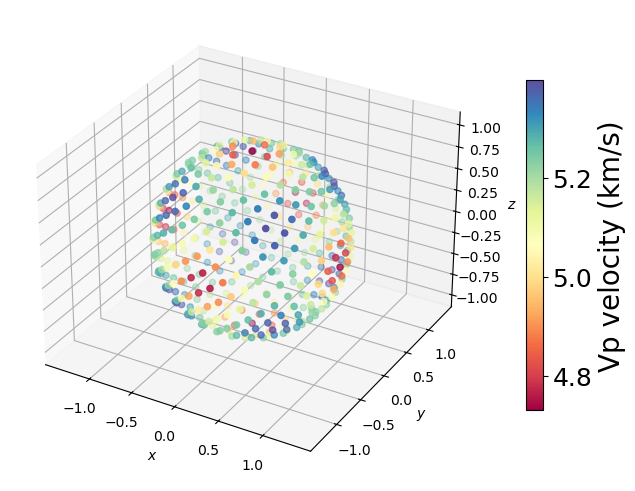

In [13]:
# plot to test
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)
speed = ax.scatter(x, y, z, c=phase_velocities[:, 2], cmap='Spectral')
ax.axis('equal')
ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

# add color bar
cbar = fig.colorbar(speed, ax=ax, shrink=0.7, location='right')
cbar.set_label('Vp velocity (km/s)', fontsize=20)
cbar.ax.tick_params(labelsize=18)

## Determining the group velocities ($v_g$)

**Group velocity** is the speed at which a wave packet (the "entire energy pulse") travels through a medium. It represents the velocity of the entire wave group, comprising multiple frequencies travelling together. In dispersive media, phase and group velocities can differ. In seismology, group velocities are often more relevant than phase velocities, as they represent the speed of energy propagation and are used for predicting the arrival times of seismic phases. Group velocity is defined as the derivative of the wave’s angular frequency with respect to its wave number and is related to phase velocity as follows:

$$
v_g = \frac{\partial \omega}{\partial \kappa} = \vec{\varDelta} v_p
$$

In order to estimate the group velocities, it is first necessary to estimate the derivatives (gradients) of the Christoffel matrix and the eigenvalues for each direction.

## Step 6: Calculate the derivatives of the Christoffel matrices ($∇M_{ilk}$)

The gradient of the Christoffel matrix for a given direction is determined as follows (e.g. Jaeken and Cottenier, 2016):

$$
∇M_{ilk} = \frac{\partial M_{il}}{\partial q_k} = \sum_m (C_{ikmj} + C_{imkj}) q_m
$$

For each direction, the result is reshaped to a 3D matrix with shape (3, 3, 3) resuting in an array of shape (n, 3, 3, 3).

In [14]:
dMilk = ch._christoffel_gradient_matrix(wavevectors, Cijkl)

dMilk.shape

(450, 3, 3, 3)

## Step 7: Calculate the derivative of the eigenvalues $\vec{\varDelta} \lambda$

The first derivative of an eigenvalue $\lambda$ of a matrix $M$ is given by:

$$
\vec{\varDelta} \lambda = \frac{\partial \lambda_i}{\partial q_k} = \hat{s}_i \cdot ∇M_{ilk} \cdot \hat{s}_i
$$

where $\hat{s}_i$ is the normalized eigenvector corresponding to eigenvalue $\lambda_i$.

In [15]:
eigenvalue_gradients = ch._eigenvalue_derivatives(eigenvectors, dMilk)

eigenvalue_gradients.shape

(450, 3, 3)

## Step 8: Calculate the Group velocities ($v_g$)


### Step 8.1: Calculate group velocity matrices

$$
v_g = \vec{\varDelta} v_p = \vec{\varDelta} \sqrt{\lambda} = \frac{\vec{\varDelta} \lambda}{2 \sqrt{\lambda}} = \frac{\vec{\varDelta} \lambda}{2 v_p}
$$

In [16]:
phase_velocities_reshaped = phase_velocities[:, :, np.newaxis]
group_velocities = eigenvalue_gradients / (2 * phase_velocities_reshaped)

group_velocities.shape

(450, 3, 3)

### Step 8.2: Calculate the magnitudes of group velocities

In [17]:
group_velocity_magnitudes = np.linalg.norm(group_velocities, axis=2)

group_velocity_magnitudes.shape

(450, 3)

In [18]:
# display the first ten directions
group_velocity_magnitudes[:10]

array([[17.75488102, 17.75488102, 25.10919354],
       [26.55988968, 17.75488102, 22.53753526],
       [17.55089769, 20.07852322, 25.52255753],
       [20.7581618 , 22.72141005, 23.46868979],
       [27.76084197, 21.48549935, 21.54844796],
       [32.82474072, 17.90867688, 20.14843909],
       [27.53796823, 26.21150498, 19.78026365],
       [18.69947453, 28.05020057, 22.31781173],
       [17.93107493, 31.21136785, 21.28368726],
       [19.24616973, 17.33475982, 26.77048673]])

> This wave velocities are not normalized by the density of the material!

### Step 8.3: Calculate the directions of group velocities (unit vectors)

In [19]:
epsilon = 1e-10  # Add a small epsilon to avoid division by zero
group_velocity_directions = group_velocities / (group_velocity_magnitudes[:, :, np.newaxis] + epsilon)

group_velocity_directions.shape

(450, 3, 3)

### Step 8.4: Calculate the power flow angles ($\psi$)

The power flow angle is the angle between vector $\vec{n}$ (normal to the slowness surface) and $\vec{l}$ (the direction normal to the wavefront).

TODO

$$
v_p = v_g \, cos(\psi)
$$


In [20]:
cos_power_flow_angles = np.zeros((wavevectors.shape[0], 3))

# TODO: remove using numpy broadcasting rules!!
for i in range(wavevectors.shape[0]):
    cos_power_flow_angles = np.dot(group_velocity_directions, wavevectors[i])

power_flow_angles = np.arccos(np.clip(cos_power_flow_angles, -1, 1))
#power_flow_angles = np.arccos(np.around(cos_power_flow_angles, decimals=10))

power_flow_angles.shape

(450, 3)

## Step 9: Calculate enhacement factor ($A$)

The group velocity direction is the direction in which the energy travels. As this is generally not the same as the phase velocity direction, there will be variations in the power flow concentration as a function of direction. This effect is quantified by a parameter called the _enhancement factor_ defined as

$$
A = \frac{\varDelta\Omega_k}{\varDelta\Omega_g}
$$

TODO

### Step 9.1: Calculate the Hessian of the Christoffel matrix

In [21]:
# TODO

### Step 9.2: Compute the Hessian of eigenvalues

In [22]:
# TODO

### Step 9.3: Determine the enhancement factors

In [23]:
# TODO

## Pandas output

In [24]:
data = pd.DataFrame({
    'polar_ang': np.around(np.rad2deg(polar), 1),
    'azimuthal_ang': np.around(np.rad2deg(azimuths), 1),
    'phase_Vp': phase_velocities[:, 2],
    'phase_Vs1': phase_velocities[:, 1],
    'phase_Vs2': phase_velocities[:, 0],
    'group_Vp': group_velocity_magnitudes[:, 2],
    'group_Vs1': group_velocity_magnitudes[:, 1],
    'group_Vs2': group_velocity_magnitudes[:, 0]
})

In [25]:
data

,polar_ang,azimuthal_ang,phase_Vp,phase_Vs1,phase_Vs2,group_Vp,group_Vs1,group_Vs2
0,0.0,0.0,4.731335,3.345559,3.345559,25.109194,17.754881,17.754881
1,9.8,0.0,4.812982,3.345559,3.226995,22.537535,17.754881,26.559890
2,11.2,222.5,4.836447,3.317070,3.221318,25.522558,20.078523,17.550898
3,12.4,85.0,4.854540,3.344671,3.165071,23.468690,22.721410,20.758162
4,13.6,307.5,4.877352,3.307152,3.169422,21.548448,21.485499,27.760842
...,...,...,...,...,...,...,...,...
445,166.4,146.6,4.876995,3.311479,3.165452,26.085941,17.028408,20.282967
446,167.6,9.0,4.854745,3.342711,3.166828,26.198323,17.960696,18.433161
447,168.8,231.5,4.836353,3.318637,3.219843,25.428975,20.628592,17.562545
448,170.2,94.0,4.813008,3.345199,3.227329,24.088264,21.434537,19.575681


**I think I need to normalize the ``eigenvalue_gradients`` or ``group_velocities``  before calculating the group velocity magnitudes**

In [26]:
(data['group_Vp'] / density) / data['phase_Vp']

0      1.000000
1      0.882355
2      0.994372
3      0.910944
4      0.832497
         ...   
445    1.007871
446    1.016853
447    0.990745
448    0.943061
449    1.000000
Length: 450, dtype: float64

In [27]:
data['group_Vp'] / density

0      4.731335
1      4.246756
2      4.809225
3      4.422214
4      4.060382
         ...   
445    4.915384
446    4.936560
447    4.791591
448    4.538961
449    4.731335
Name: group_Vp, Length: 450, dtype: float64


---
# TEST

In [28]:
def set_group_velocity(phase_vel, eig_vec, gradmat, direction):
    """
    Implementation of group velocities by Jeken and Cottenier
    removing from the Christoffel class and refactored
    """

    # Variables initialization
    grad_eig = np.empty((3, 3))
    group_vel = np.empty((3, 3))
    _group_abs = np.empty(3)
    _group_dir = np.empty((3, 3))
    group_theta = np.empty(3)
    group_phi = np.empty(3)


    for pol in range(3):
        for cart in range(3):
            grad_eig[pol][cart] = np.dot(
                eig_vec[pol], np.dot(gradmat[cart], eig_vec[pol])
            )
            # Eigenvalues are the square of the velocity
            # dv/dq = dv^2/dq / (2v)
            group_vel[pol][cart] = grad_eig[pol][cart] / (2 * phase_vel[pol])
        _group_abs[pol] = np.linalg.norm(group_vel[pol])
        _group_dir[pol] = group_vel[pol] / _group_abs[pol]  # why?

        x = _group_dir[pol][0]
        z = _group_dir[pol][2]
        if z >= 1.0 - 1e-10 or z <= -1.0 + 1e-10:
            group_theta[pol] = 0.0
            group_phi[pol] = 0.0
        else:
            group_theta[pol] = np.arccos(z)
            sin_theta = np.sqrt(1 - z**2)
            if abs(x) > sin_theta:
                group_phi[pol] = (1.0 - np.sign(x)) * 0.5 * np.pi
            else:
                group_phi[pol] = np.arccos(x / sin_theta)
            if _group_dir[pol][1] < 0.0:
                group_phi[pol] = 2 * np.pi - group_phi[pol]
    
    _cos_pf_angle = np.dot(_group_dir, direction)
    powflow_angle = np.arccos(np.around(_cos_pf_angle, 10))

    return grad_eig, group_vel, _group_abs, _group_dir, powflow_angle, group_theta, group_phi


In [29]:
res1, res2, res3, res4, res5, thetas, phis = set_group_velocity(phase_velocities[5], eigenvectors[5], dMilk[5], wavevectors[5])

### eigenvalue derivatives

In [30]:
# gradients (derivatives) of eigenvalues
res1

array([[-133.42561669,   21.32574585,  153.13073556],
       [ -30.35018512,  -10.78150255,  115.24183953],
       [  45.78019137,   10.32751876,  191.4713609 ]])

In [31]:
eigenvalue_gradients[5]  # NICE!

array([[-133.42561669,   21.32574585,  153.13073556],
       [ -30.35018512,  -10.78150255,  115.24183953],
       [  45.78019137,   10.32751876,  191.4713609 ]])

---

### Group velocity matrices

In [32]:
# Group velocity
res2

array([[-21.44569807,   3.42771889,  24.61293117],
       [ -4.54237322,  -1.61361812,  17.24771839],
       [  4.67893025,   1.05551634,  19.56918738]])

In [33]:
group_velocities[5]

array([[-21.44569807,   3.42771889,  24.61293117],
       [ -4.54237322,  -1.61361812,  17.24771839],
       [  4.67893025,   1.05551634,  19.56918738]])

---

### Group velocity magnitudes

In [34]:
# magnitude of the group velocity for each mode
res3

array([32.82474072, 17.90867688, 20.14843909])

In [35]:
group_velocity_magnitudes[5]

array([32.82474072, 17.90867688, 20.14843909])

---

### Group velocity directions

In [36]:
# direction of the group velocity for each mode
res4

array([[-0.65333945,  0.10442486,  0.74982865],
       [-0.25364092, -0.09010259,  0.96309284],
       [ 0.23222296,  0.052387  ,  0.97125079]])

In [37]:
group_velocity_directions[5]

array([[-0.65333945,  0.10442486,  0.74982865],
       [-0.25364092, -0.09010259,  0.96309284],
       [ 0.23222296,  0.052387  ,  0.97125079]])

---

### Powerflow angles

In [38]:
# Powerflow angle (in radians)
res5

array([0.46813036, 0.13431025, 0.48536834])

In [39]:
power_flow_angles[5]

array([2.41859939, 2.86906211, 2.90122615])

---
### Spherical angles (polar, azimuthal == thethas & phis) for a given velocity group directions (3D vectors)

In [40]:
thetas

array([0.72299326, 0.27253055, 0.24036651])

In [41]:
phis

array([2.98310074, 3.48292513, 0.22187522])